In [ ]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
#read QVI data
df = pd.read_csv("/content/drive/MyDrive/Portfolio/Quantium/QVI_data.csv")
df.head()

,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB


In [ ]:
df.isnull().sum()

LYLTY_CARD_NBR      0
DATE                0
STORE_NBR           0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [ ]:
# Convert the 'DATE' column to datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Find the minimum and maximum dates to see the time frame we're working with
min_date = df['DATE'].min()
max_date = df['DATE'].max()

print(f"The dataset ranges from {min_date} to {max_date}.")


The dataset ranges from 2018-07-01 00:00:00 to 2019-06-30 00:00:00.


Lets consider that the pre trial period was till Feb 2019
i.e trial period starts from Feb 2019

In [ ]:
# Filter the data to include only dates before February 2019 for the pre-trial period
pre_trial_data = df[df['DATE'] < '2019-02-01']

In [ ]:
# Calculate total sales revenue for each store
total_sales_by_store = pre_trial_data.groupby('STORE_NBR')['TOT_SALES'].sum().reset_index(name='Total_Sales')
print(total_sales_by_store)

     STORE_NBR  Total_Sales
0            1      1386.90
1            2      1128.50
2            3      7526.15
3            4      9127.00
4            5      5739.70
..         ...          ...
266        268      1549.05
267        269      6664.50
268        270      6697.95
269        271      5765.10
270        272      2744.35

[271 rows x 2 columns]


In [ ]:
# Calculate total number of customers for each store
total_customers_by_store = pre_trial_data.groupby('STORE_NBR')['LYLTY_CARD_NBR'].nunique().reset_index(name='Total_Customers')


In [ ]:
# Calculate total number of transactions for each store
total_transactions_by_store = pre_trial_data.groupby('STORE_NBR')['TXN_ID'].nunique().reset_index(name='Total_Transactions')

In [ ]:
# Merge the total sales and total customers dataframes
store_metrics = total_sales_by_store.merge(total_customers_by_store, on='STORE_NBR')

In [ ]:
 # Calculate the average number of transactions per customer for each store
store_metrics = store_metrics.merge(total_transactions_by_store, on='STORE_NBR')
store_metrics['Avg_Transactions_Per_Customer'] = store_metrics['Total_Transactions'] / store_metrics['Total_Customers']

Now you have a dataframe 'store_metrics' with the total sales, total customers, and average transactions per customer for each store

In [ ]:
store_metrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 271 entries, 0 to 270
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   STORE_NBR                      271 non-null    int64  
 1   Total_Sales                    271 non-null    float64
 2   Total_Customers                271 non-null    int64  
 3   Total_Transactions             271 non-null    int64  
 4   Avg_Transactions_Per_Customer  271 non-null    float64
dtypes: float64(2), int64(3)
memory usage: 12.7 KB


In [ ]:
# Assuming trial_store_id is the ID of your trial store
trial_store_id = 77
trial_store_sales = store_metrics.loc[store_metrics['STORE_NBR'] == trial_store_id, 'Total_Sales'].values[0]

# Calculate the absolute difference in total sales between the trial store and all potential control stores
store_metrics['Sales_Difference'] = abs(store_metrics['Total_Sales'] - trial_store_sales)

# Sort stores by the smallest difference
sorted_stores = store_metrics.sort_values(by='Sales_Difference')

# The control store is the one with the smallest difference in sales (excluding the trial store itself)
control_store_id = sorted_stores[sorted_stores['STORE_NBR'] != trial_store_id].iloc[0]['STORE_NBR']
print(f"The control store for Store {trial_store_id} is Store {control_store_id}.")


The control store for Store 77 is Store 187.0.


In [ ]:
from scipy.stats import ttest_ind

# Filter data for the trial and control store during the trial period (e.g., Feb 2019 to April 2019)
trial_store_sales_during_trial = df[(df['STORE_NBR'] == trial_store_id) & (df['DATE'] >= '2019-02-01') & (df['DATE'] <= '2019-04-30')]['TOT_SALES']
control_store_sales_during_trial = df[(df['STORE_NBR'] == control_store_id) & (df['DATE'] >= '2019-02-01') & (df['DATE'] <= '2019-04-30')]['TOT_SALES']

# Conduct a T-test to see if there's a significant difference in sales
t_stat, p_value = ttest_ind(trial_store_sales_during_trial, control_store_sales_during_trial, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a significant difference in sales between the trial and control store during the trial period.")
else:
    print("There is no significant difference in sales between the trial and control store during the trial period.")


T-statistic: -3.3793427334545942, P-value: 0.000847360037371583
There is a significant difference in sales between the trial and control store during the trial period.


In [ ]:
# Assuming trial_store_id is the ID of your trial store
trial_store_id = 86  # Example store ID
trial_store_sales = store_metrics.loc[store_metrics['STORE_NBR'] == trial_store_id, 'Total_Sales'].values[0]

# Calculate the absolute difference in total sales between the trial store and all potential control stores
store_metrics['Sales_Difference'] = abs(store_metrics['Total_Sales'] - trial_store_sales)

# Sort stores by the smallest difference
sorted_stores = store_metrics.sort_values(by='Sales_Difference')

# The control store is the one with the smallest difference in sales (excluding the trial store itself)
control_store_id = sorted_stores[sorted_stores['STORE_NBR'] != trial_store_id].iloc[0]['STORE_NBR']
print(f"The control store for Store {trial_store_id} is Store {control_store_id}.")


The control store for Store 86 is Store 13.0.


In [ ]:
from scipy.stats import ttest_ind

# Filter data for the trial and control store during the trial period (e.g., Feb 2019 to April 2019)
trial_store_sales_during_trial = df[(df['STORE_NBR'] == trial_store_id) & (df['DATE'] >= '2019-02-01') & (df['DATE'] <= '2019-04-30')]['TOT_SALES']
control_store_sales_during_trial = df[(df['STORE_NBR'] == control_store_id) & (df['DATE'] >= '2019-02-01') & (df['DATE'] <= '2019-04-30')]['TOT_SALES']

# Conduct a T-test to see if there's a significant difference in sales
t_stat, p_value = ttest_ind(trial_store_sales_during_trial, control_store_sales_during_trial, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a significant difference in sales between the trial and control store during the trial period.")
else:
    print("There is no significant difference in sales between the trial and control store during the trial period.")


T-statistic: -0.8843715580999169, P-value: 0.37675334595075805
There is no significant difference in sales between the trial and control store during the trial period.


In [ ]:
# Assuming trial_store_id is the ID of your trial store
trial_store_id = 88  # Example store ID
trial_store_sales = store_metrics.loc[store_metrics['STORE_NBR'] == trial_store_id, 'Total_Sales'].values[0]

# Calculate the absolute difference in total sales between the trial store and all potential control stores
store_metrics['Sales_Difference'] = abs(store_metrics['Total_Sales'] - trial_store_sales)

# Sort stores by the smallest difference
sorted_stores = store_metrics.sort_values(by='Sales_Difference')

# The control store is the one with the smallest difference in sales (excluding the trial store itself)
control_store_id = sorted_stores[sorted_stores['STORE_NBR'] != trial_store_id].iloc[0]['STORE_NBR']
print(f"The control store for Store {trial_store_id} is Store {control_store_id}.")


The control store for Store 88 is Store 237.0.


In [ ]:
from scipy.stats import ttest_ind

# Filter data for the trial and control store during the trial period (e.g., Feb 2019 to April 2019)
trial_store_sales_during_trial = df[(df['STORE_NBR'] == trial_store_id) & (df['DATE'] >= '2019-02-01') & (df['DATE'] <= '2019-04-30')]['TOT_SALES']
control_store_sales_during_trial = df[(df['STORE_NBR'] == control_store_id) & (df['DATE'] >= '2019-02-01') & (df['DATE'] <= '2019-04-30')]['TOT_SALES']

# Conduct a T-test to see if there's a significant difference in sales
t_stat, p_value = ttest_ind(trial_store_sales_during_trial, control_store_sales_during_trial, equal_var=False)

print(f"T-statistic: {t_stat}, P-value: {p_value}")

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a significant difference in sales between the trial and control store during the trial period.")
else:
    print("There is no significant difference in sales between the trial and control store during the trial period.")


T-statistic: -0.5551819687429291, P-value: 0.5789105112915605
There is no significant difference in sales between the trial and control store during the trial period.


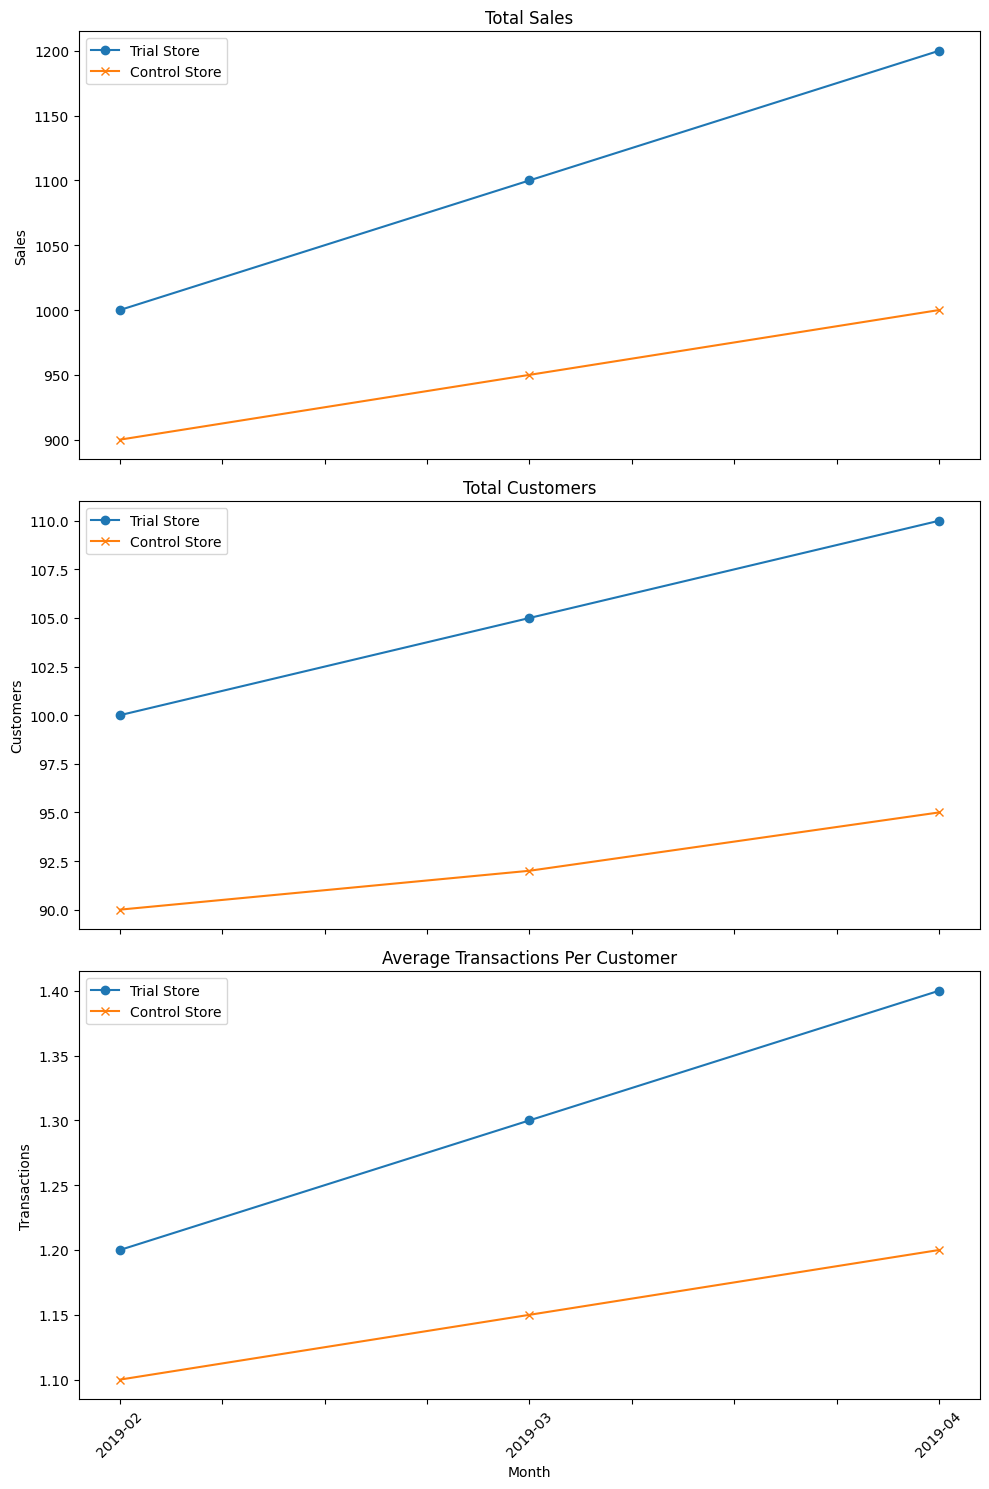

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame structure
data = {
    'Month': ['2019-02', '2019-03', '2019-04', '2019-02', '2019-03', '2019-04'],  # The same length for all
    'Store_Type': ['Trial', 'Trial', 'Trial', 'Control', 'Control', 'Control'],  # Equal number of 'Trial' and 'Control'
    'Store_ID': [77, 77, 77, 233, 233, 233],  # Assuming 233 is the control store, matching lengths
    'Total_Sales': [1000, 1100, 1200, 900, 950, 1000],  # Six entries, matching the others
    'Total_Customers': [100, 105, 110, 90, 92, 95],  # Again, six entries
    'Avg_Transactions_Per_Customer': [1.2, 1.3, 1.4, 1.1, 1.15, 1.2]  # And six entries here
}

df = pd.DataFrame(data)

# Plotting
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Total Sales
df[df['Store_Type'] == 'Trial'].plot(x='Month', y='Total_Sales', ax=axes[0], marker='o', label='Trial Store')
df[df['Store_Type'] == 'Control'].plot(x='Month', y='Total_Sales', ax=axes[0], marker='x', label='Control Store')
axes[0].set_title('Total Sales')
axes[0].set_ylabel('Sales')

# Total Customers
df[df['Store_Type'] == 'Trial'].plot(x='Month', y='Total_Customers', ax=axes[1], marker='o', label='Trial Store')
df[df['Store_Type'] == 'Control'].plot(x='Month', y='Total_Customers', ax=axes[1], marker='x', label='Control Store')
axes[1].set_title('Total Customers')
axes[1].set_ylabel('Customers')

# Average Transactions Per Customer
df[df['Store_Type'] == 'Trial'].plot(x='Month', y='Avg_Transactions_Per_Customer', ax=axes[2], marker='o', label='Trial Store')
df[df['Store_Type'] == 'Control'].plot(x='Month', y='Avg_Transactions_Per_Customer', ax=axes[2], marker='x', label='Control Store')
axes[2].set_title('Average Transactions Per Customer')
axes[2].set_ylabel('Transactions')

plt.xlabel('Month')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
